In [84]:
import heapq
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np


MAX_THETA = np.deg2rad(60.0)  # [rad] maximum steering angle
L = 3.0
N_STEER = 10
MAX_ACC = 5.0
MIN_ACC = -10.0
N_ACC = 15
N_THATA = 20  # number of steer command

N_T = int(MAX_T/T_GRID_RESOLUTION)


STEER_CHANGE_COST = 0.5  # steer angle change penalty cost
STEER_COST = 0.2  # steer angle change penalty cost
ACC_CHANGE_COST = 0.5
ACC_COST = 0.2
H_COST = 5.0  # Heuristic cost

class Node:
    def __init__(self, t_ind, x_ind, y_ind, yaw_ind, v_ind, 
                 t, x, y, yaw, v, theta=0.0, acc=0.0, 
                 parent_index=None, cost=None):
        self.t_index = t_ind
        self.x_index = x_ind
        self.y_index = y_ind
        self.yaw_index = yaw_ind
        self.v_index = v_ind
        self.t = t
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.theta = theta
        self.acc = acc
        self.parent_index = parent_index
        self.cost = cost
    
class Path:
    def __init__(self, t_list, x_list, y_list, yaw_list, v_list, cost):
        self.t_list = t_list
        self.x_list = x_list
        self.y_list = y_list
        self.yaw_list = yaw_list
        self.v_list = v_list
        self.cost = cost


def pi_2_pi(angle):
    return (angle + pi) % (2 * pi) - pi

def calc_motion_inputs():
    for theta in np.concatenate((np.linspace(-MAX_THETA, MAX_THETA, N_THATA), [0.0])):
        for acc in np.concatenate((np.linspace(MIN_ACC, MAX_ACC, N_ACC), [0.0])):
            yield [theta, acc]
            
def move(x, y, yaw, v, theta, acc):
    v += acc*T_GRID_RESOLUTION
    yaw += theta
    x += v * cos(yaw) * T_GRID_RESOLUTION
    y += v * sin(yaw) * T_GRID_RESOLUTION
    return x, y, yaw, v

            
def verify_index(node, c):
    t_ind, x_ind, y_ind, v_ind = node.t, node.x_index, node.y_index, node.v_index
    if (0 <= x_ind < c.x_w-1) and (0 <= y_ind < c.y_w-1) and (0 <= t_ind < c.t_w-2) and (0 <= v_ind < c.v_w-1):
        return True

    return False     

def calc_index(node, c):
    ind = (node.t_index * c.x_w * c.y_w * c.yaw_w * c.v_w +
           node.v_index * c.x_w * c.y_w * c.yaw_w + 
           node.yaw_index  * c.x_w * c.y_w +
           node.y_index  * c.x_w + 
           node.x_index)

    if ind < 0:
        print("Error(calc_index):", ind)

    return ind

def isNodeFree(node, st_grid_map, c):
    t_ind, x_ind, y_ind = node.t_index, node.x_index, node.y_index
    if (0 <= x_ind < c.x_w-1) and (5 <= y_ind < c.y_w-5) and (0 <= t_ind < c.t_w):    
        if st_grid_map[t_ind, x_ind, y_ind] > 0:
#             if (node.y > 3.0 or node.y < -3.0):
#                 print(st_grid_map[t_ind, x_ind, y_ind], t_ind, x_ind, y_ind)
            return True
    return False

def get_neighbors(current, config, st_grid_map):
    for theta, acc in calc_motion_inputs():
        node = calc_next_node(current, theta, acc, config)
        if node and verify_index(node, config) and isNodeFree(node, st_grid_map, config):
            yield node
            
def calc_next_node(current, theta, acc, config):
    x, y, yaw, v = current.x, current.y, current.yaw, current.v
    x, y, yaw, v = move(x, y, yaw, v, theta, acc)
    if np.cos(yaw) < 0.0 or v < 0.0 or v > MAX_V: return None 
    x_ind = round(x / XY_GRID_RESOLUTION) - config.min_x
    y_ind = round(y / XY_GRID_RESOLUTION) - config.min_y
    yaw_ind = round(yaw / YAW_GRID_RESOLUTION) - config.min_yaw
    v_ind = round(v / V_GRID_RESOLUTION) - config.min_v
    
    e = pow((current.x - x)**2+(current.y - y)**2, 0.5)
    c = abs(v - MAX_V)
    d = x - current.x    
    cost = 0.65*e + c - 5.0*d
    node = Node(current.t_index+1, x_ind, y_ind, yaw_ind, v_ind, 
                current.t+T_GRID_RESOLUTION, x, y, yaw, v, theta=theta, acc=acc, 
                parent_index=calc_index(current, config), 
                cost=cost)
    return node
    
    
def is_same_grid(n1, n2):
    if ((n1.t_index == n2.t_index)
        and (n1.x_index == n2.x_index)
        and (n1.y_index == n2.y_index)
        and (n1.yaw_index == n2.yaw_index)
        and (n1.v_index == n2.v_index)):
        return True
    return False

def culcontrolpoints(p1, p2):
    control_points = np.zeros((2, 4))
    control_points[:,0] = p1[0:2]
    control_points[:,3] = p2[0:2]
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    d = np.sqrt(dx*dx+dy*dy)/3.0
    control_points[:,1] = np.array([p1[0]+d*np.cos(p1[2]), p1[1]+d*np.sin(p1[2])])
    control_points[:,2] = np.array([p2[0]-d*np.cos(p2[2]), p2[1]-d*np.sin(p2[2])])
    return control_points
    

def recursive(control_points, T, B0=0, B1=0, dB0=0, dB1=0, ddB0=0, ddB1=0):
    if len(control_points) == 1:
        return control_points[0], -B0+(1-T)*dB0+B1+T*dB1, -2*dB0+(1-T)*ddB0+2*dB1+T*ddB1
    else:
        B0, dB0, ddB0 = recursive(control_points[0:-1], T)
        B1, dB1, ddB1 = recursive(control_points[1:], T)
        return (1-T)*B0 + T*B1 , -B0+(1-T)*dB0+B1+T*dB1, -2*dB0+(1-T)*ddB0+2*dB1+T*ddB1

def cullengthofcurve(x, y):
    s = 0
    for i in range(len(x)-1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        s += np.sqrt(dx*dx+dy*dy)
    return s

def calc_cost(n, goal_node, c):
    h = abs(n.y-goal_node.y)
    return n.cost + h

def get_final_path(closed, goal_node):
    reversed_t = []
    reversed_x = []
    reversed_y = []
    reversed_yaw = []
    reversed_v = []
        
    nid = goal_node.parent_index
    final_cost = goal_node.cost
    while nid:
        n = closed[nid]
        reversed_t.append(n.t)
        reversed_x.append(n.x)
        reversed_y.append(n.y)
        reversed_yaw.append(n.yaw)
        reversed_v.append(n.v)
        nid = n.parent_index
    reversed_t = list(reversed(reversed_t))
    reversed_x = list(reversed(reversed_x))
    reversed_y = list(reversed(reversed_y))
    reversed_yaw = list(reversed(reversed_yaw))
    reversed_v = list(reversed(reversed_v))
    
    path = Path(reversed_t, reversed_x, reversed_y, reversed_yaw, reversed_v, final_cost)

    return path

def STAStar_planning(start, goal, st_grid_map, xy_resolution, yaw_resolution):
    start[2], goal[2] = pi_2_pi(start[2]), pi_2_pi(goal[2])
    config = Config(0.0, 50.0, -4.5, 4.5, xy_resolution, yaw_resolution)
    start_node = Node(0, round(start[0] / xy_resolution) - config.min_x,
                      round(start[1] / xy_resolution) - config.min_y,
                      round(start[2] / yaw_resolution) - config.min_yaw,
                      round(start[3] / V_GRID_RESOLUTION) - config.min_v,
                      0.0, start[0], start[1], start[2], start[3], cost=0.0)
    goal_node = Node(config.t_w-1, round(goal[0] / xy_resolution) - config.min_x,
                      round(goal[1] / xy_resolution) - config.min_y,
                      round(goal[2] / yaw_resolution) - config.min_yaw,
                      round(goal[3] / V_GRID_RESOLUTION) - config.min_v,
                      MAX_T, goal[0], goal[1], goal[2], goal[3], cost=0.0)
    openList, closedList = {}, {}
    pq = []
    openList[calc_index(start_node, config)] = start_node
    heapq.heappush(pq, (calc_cost(start_node, goal_node, config),
                        calc_index(start_node, config)))
    final_path = None
    ite = 0
    while ite < 50000:
        if not openList:
            print("Error: Cannot find path, No open set")
            return [], [], []
        
        cost, c_id = heapq.heappop(pq)
        if c_id in openList:
            current = openList.pop(c_id)
            closedList[c_id] = current
        else: continue
            
        if  ((current.t_index == goal_node.t_index)
            and (current.y_index == goal_node.y_index)):
            print("path found")
            goal_node.t_index = current.t_index
            goal_node.t = current.t
            goal_node.cost = current.cost
            goal_node.parent_index = calc_index(current, config)
            break
        for neighbor in get_neighbors(current, config, st_grid_map):
            neighbor_index = calc_index(neighbor, config)
            if neighbor_index in closedList.keys():
                continue
            if (neighbor_index not in openList.keys()) or (openList[neighbor_index].cost > neighbor.cost):
                heapq.heappush(pq, (calc_cost(neighbor, goal_node, config), neighbor_index))
                openList[neighbor_index] = neighbor
        ite += 1
            
    path = get_final_path(closedList, goal_node)
    return path            

In [1]:
import numpy as np
import math
import copy
import time

dt = T_GRID_RESOLUTION = 0.1
XY_GRID_RESOLUTION = 0.3
YAW_GRID_RESOLUTION = np.deg2rad(15.0)
V_GRID_RESOLUTION = 1.0
MAX_T = 5.0
MAX_V = 10.0

class Config:
    def __init__(self, min_x_m, max_x_m, min_y_m, max_y_m,
                 xy_resolution, yaw_resolution):
        self.min_t = 0
        self.max_t = round(MAX_T / T_GRID_RESOLUTION)
        self.t_w = round(self.max_t - self.min_t) + 1
        
        self.min_x = round(min_x_m / xy_resolution)
        self.min_y = round(min_y_m / xy_resolution)
        self.max_x = round(max_x_m / xy_resolution)
        self.max_y = round(max_y_m / xy_resolution)
        
        self.x_w = round(self.max_x - self.min_x) + 1
        self.y_w = round(self.max_y - self.min_y) + 1
        
        self.min_yaw = round(- math.pi / yaw_resolution)
        self.max_yaw = round(math.pi / yaw_resolution)
        self.yaw_w = round(self.max_yaw - self.min_yaw) + 1
        
        self.min_v = 0
        self.max_v = round(MAX_V / V_GRID_RESOLUTION)
        self.v_w = round(self.max_v - self.min_v) + 1

class Point:
    def __init__(self, x, y, phi):
        self.x = x
        self.y = y
        self.phi = phi

class Box2D(object):
    def __init__(self, x0, y0, phi0, v0, L, W, lanetype):
        self.lanetype = lanetype
        self.x = x0
        self.y = y0
        self.phi = phi0
        self.v = v0
        self.L = L
        self.W = W
        self.traj = [Point(x0, y0, phi0)]
        self.get_traj()
    def get_traj(self):
        for i in range(1, config.t_w):
            x = self.x + self.v*i*dt*np.cos(self.phi)
            y = self.y + self.v*i*dt*np.sin(self.phi)
            self.traj.append(Point(x, y, self.phi))
            
def get_test_points(obs, point):    
    num_l, num_w = 100, 100
    point_buf = np.zeros((num_l*num_w, 2))
    for i, l in enumerate(np.linspace(-(obs.L+egoL)/2.0, (obs.L+egoL)/2.0, num_l)):
        for j, w in enumerate(np.linspace(-(obs.W+egoW)/2.0, (obs.W+egoW)/2.0, num_w)):
            point_buf[i*num_l+j] = np.array([point.x+l*np.cos(point.phi)+w*np.cos(point.phi-(np.pi/2.0)), 
                                             point.y+l*np.sin(point.phi)+w*np.sin(point.phi-(np.pi/2.0))])    
    
    return point_buf.T

def XY2mapIndex2(point, c):
    y_index = np.round(point[1]/XY_GRID_RESOLUTION) - c.min_y
    x_index = np.round(point[0]/XY_GRID_RESOLUTION) - c.min_x
    if len(point[0]) == 1: return int(x_index[0]), int(y_index[0])
    y_index = np.where((y_index >= 0)&(y_index < c.y_w), y_index, -1)
    x_index = np.where((x_index >= 0)&(x_index < c.x_w), x_index, -1)
    x_dels = np.argwhere(x_index == -1)
    y_dels = np.argwhere(y_index == -1)
    af_y_index = np.array([y_index[i] for i in range(len(y_index))  if y_index[i] != -1 and x_index[i] != -1])
    af_x_index = np.array([x_index[i] for i in range(len(x_index))  if y_index[i] != -1 and x_index[i] != -1])
    return [af_x_index.astype(int), af_y_index.astype(int)]

config = Config(0.0, 50.0, -4.5, 4.5, XY_GRID_RESOLUTION, YAW_GRID_RESOLUTION)
obs0 = Box2D(12.0, -1.5, 0.0, 0.4, 1.0, 1.5, "M")
egoL = 2.0
egoW = 1.0
obs_buf = [obs0]
map_grid = np.full((config.t_w, config.x_w, config.y_w), int(10), dtype=np.int8)
map_grid[:,:, 0:8] = 0
map_grid[:,:, config.y_w-8:] = 0

for obs in obs_buf:
    for t, test_point in enumerate(obs.traj):
        points = get_test_points(obs, test_point)
        x_index, y_index = XY2mapIndex2(points, config)
        map_grid[t, x_index, y_index] = 0

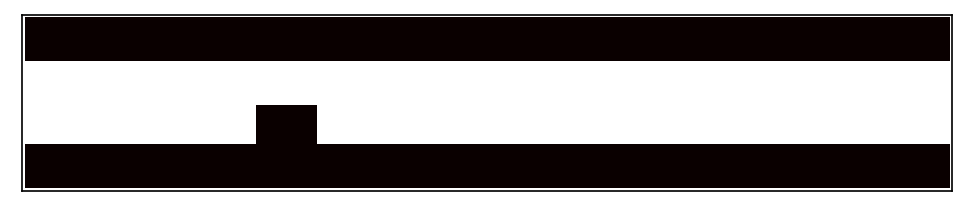

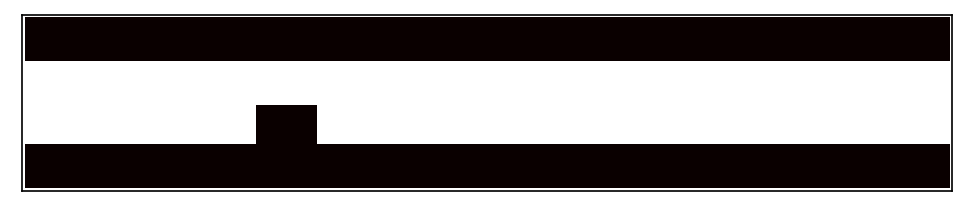

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
plt.figure(figsize=(8, 100), dpi=150)


        
for t in range(int(MAX_T/T_GRID_RESOLUTION)):    
    plt.clf()
    plt.imshow(map_grid[t].T, cmap=plt.cm.hot, interpolation='nearest', vmin=0, vmax=10)
    # plt.colorbar()
    plt.xlim(-1, config.x_w)  # 设置x轴范围
    plt.ylim(-1, config.y_w)  # 设置y轴范围
    my_x_ticks = np.arange(0, config.x_w, 1)
    my_y_ticks = np.arange(0, config.y_w, 1)
    plt.xticks([])
    plt.yticks([])    
    plt.grid(True)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [8]:
import heapq
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np


MAX_THETA = np.deg2rad(60.0)  # [rad] maximum steering angle
L = 3.0
N_STEER = 10
MAX_ACC = 5.0
MIN_ACC = -10.0
N_ACC = 15
N_THATA = 20  # number of steer command

N_T = int(MAX_T/T_GRID_RESOLUTION)

class Node:
    def __init__(self, t_ind, x_ind, y_ind, yaw_ind, v_ind, 
                 t, x, y, yaw, v, theta=0.0, acc=0.0, 
                 parent_index=None, cost=None):
        self.t_index = t_ind
        self.x_index = x_ind
        self.y_index = y_ind
        self.yaw_index = yaw_ind
        self.v_index = v_ind
        self.t = t
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.theta = theta
        self.acc = acc
        self.parent_index = parent_index
        self.cost = cost
    
class Path:
    def __init__(self, t_list, x_list, y_list, yaw_list, v_list, cost):
        self.t_list = t_list
        self.x_list = x_list
        self.y_list = y_list
        self.yaw_list = yaw_list
        self.v_list = v_list
        self.cost = cost


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

def calc_motion_inputs():
    for theta in np.concatenate((np.linspace(-MAX_THETA, MAX_THETA, N_THATA), [0.0])):
        for acc in np.concatenate((np.linspace(MIN_ACC, MAX_ACC, N_ACC), [0.0])):
            yield [theta, acc]
            
def move(x, y, yaw, v, theta, acc):
    v += acc*T_GRID_RESOLUTION
    yaw += theta
    x += v * math.cos(yaw) * T_GRID_RESOLUTION
    y += v * math.sin(yaw) * T_GRID_RESOLUTION
    return x, y, yaw, v

            
def verify_index(node, c):
    t_ind, x_ind, y_ind, v_ind = node.t, node.x_index, node.y_index, node.v_index
    if (0 <= x_ind < c.x_w-1) and (0 <= y_ind < c.y_w-1) and (0 <= t_ind < c.t_w-2) and (0 <= v_ind < c.v_w-1):
        return True

    return False     

def calc_index(node, c):
    ind = (node.t_index * c.x_w * c.y_w * c.yaw_w * c.v_w +
           node.v_index * c.x_w * c.y_w * c.yaw_w + 
           node.yaw_index  * c.x_w * c.y_w +
           node.y_index  * c.x_w + 
           node.x_index)

    if ind < 0:
        print("Error(calc_index):", ind)

    return ind

def isNodeFree(node, st_grid_map, c):
    t_ind, x_ind, y_ind = node.t_index, node.x_index, node.y_index
    if (0 <= x_ind < c.x_w-1) and (5 <= y_ind < c.y_w-5) and (0 <= t_ind < c.t_w):    
        if st_grid_map[t_ind, x_ind, y_ind] > 0:
#             if (node.y > 3.0 or node.y < -3.0):
#                 print(st_grid_map[t_ind, x_ind, y_ind], t_ind, x_ind, y_ind)
            return True
    return False

def get_neighbors(current, config, st_grid_map):
    for theta, acc in calc_motion_inputs():
        node = calc_next_node(current, theta, acc, config)
        if node and verify_index(node, config) and isNodeFree(node, st_grid_map, config):
            yield node
            
def calc_next_node(current, theta, acc, config):
    x, y, yaw, v = current.x, current.y, current.yaw, current.v
    x, y, yaw, v = move(x, y, yaw, v, theta, acc)
    if np.cos(yaw) < 0.0 or v < 0.0 or v > MAX_V: return None 
    x_ind = round(x / XY_GRID_RESOLUTION) - config.min_x
    y_ind = round(y / XY_GRID_RESOLUTION) - config.min_y
    yaw_ind = round(yaw / YAW_GRID_RESOLUTION) - config.min_yaw
    v_ind = round(v / V_GRID_RESOLUTION) - config.min_v
    
    e = pow((current.x - x)**2+(current.y - y)**2, 0.5)
    c = abs(v - MAX_V)
    d = current.x - x  
    cost = 0.65*e + c + 5.0*d
    node = Node(current.t_index+1, x_ind, y_ind, yaw_ind, v_ind, 
                current.t+T_GRID_RESOLUTION, x, y, yaw, v, theta=theta, acc=acc, 
                parent_index=calc_index(current, config), 
                cost=cost)
    return node
    
    
def is_same_grid(n1, n2):
    if ((n1.t_index == n2.t_index)
        and (n1.x_index == n2.x_index)
        and (n1.y_index == n2.y_index)
        and (n1.yaw_index == n2.yaw_index)
        and (n1.v_index == n2.v_index)):
        return True
    return False

def culcontrolpoints(p1, p2):
    control_points = np.zeros((2, 4))
    control_points[:,0] = p1[0:2]
    control_points[:,3] = p2[0:2]
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    d = np.sqrt(dx*dx+dy*dy)/3.0
    control_points[:,1] = np.array([p1[0]+d*np.cos(p1[2]), p1[1]+d*np.sin(p1[2])])
    control_points[:,2] = np.array([p2[0]-d*np.cos(p2[2]), p2[1]-d*np.sin(p2[2])])
    return control_points
    

def recursive(control_points, T, B0=0, B1=0, dB0=0, dB1=0, ddB0=0, ddB1=0):
    if len(control_points) == 1:
        return control_points[0], -B0+(1-T)*dB0+B1+T*dB1, -2*dB0+(1-T)*ddB0+2*dB1+T*ddB1
    else:
        B0, dB0, ddB0 = recursive(control_points[0:-1], T)
        B1, dB1, ddB1 = recursive(control_points[1:], T)
        return (1-T)*B0 + T*B1 , -B0+(1-T)*dB0+B1+T*dB1, -2*dB0+(1-T)*ddB0+2*dB1+T*ddB1

def cullengthofcurve(x, y):
    s = 0
    for i in range(len(x)-1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        s += np.sqrt(dx*dx+dy*dy)
    return s

def calc_cost(n, goal_node, c):
    h = abs(n.y-goal_node.y)
    return n.cost + h

def get_final_path(closed, goal_node):
    reversed_t = []
    reversed_x = []
    reversed_y = []
    reversed_yaw = []
    reversed_v = []
        
    nid = goal_node.parent_index
    final_cost = goal_node.cost
    while nid:
        n = closed[nid]
        reversed_t.append(n.t)
        reversed_x.append(n.x)
        reversed_y.append(n.y)
        reversed_yaw.append(n.yaw)
        reversed_v.append(n.v)
        nid = n.parent_index
    reversed_t = list(reversed(reversed_t))
    reversed_x = list(reversed(reversed_x))
    reversed_y = list(reversed(reversed_y))
    reversed_yaw = list(reversed(reversed_yaw))
    reversed_v = list(reversed(reversed_v))
    
    path = Path(reversed_t, reversed_x, reversed_y, reversed_yaw, reversed_v, final_cost)

    return path

def STAStar_planning(start, goal, st_grid_map, xy_resolution, yaw_resolution):
    start[2], goal[2] = pi_2_pi(start[2]), pi_2_pi(goal[2])
    config = Config(0.0, 50.0, -4.5, 4.5, xy_resolution, yaw_resolution)
    start_node = Node(0, round(start[0] / xy_resolution) - config.min_x,
                      round(start[1] / xy_resolution) - config.min_y,
                      round(start[2] / yaw_resolution) - config.min_yaw,
                      round(start[3] / V_GRID_RESOLUTION) - config.min_v,
                      0.0, start[0], start[1], start[2], start[3], cost=0.0)
    goal_node = Node(config.t_w-1, round(goal[0] / xy_resolution) - config.min_x,
                      round(goal[1] / xy_resolution) - config.min_y,
                      round(goal[2] / yaw_resolution) - config.min_yaw,
                      round(goal[3] / V_GRID_RESOLUTION) - config.min_v,
                      MAX_T, goal[0], goal[1], goal[2], goal[3], cost=0.0)
    openList, closedList = {}, {}
    pq = []
    openList[calc_index(start_node, config)] = start_node
    heapq.heappush(pq, (calc_cost(start_node, goal_node, config),
                        calc_index(start_node, config)))
    final_path = None
    ite = 0
    while ite < 50000:
        if not openList:
            print("Error: Cannot find path, No open set")
            return [], [], []
        
        cost, c_id = heapq.heappop(pq)
        if c_id in openList:
            current = openList.pop(c_id)
            closedList[c_id] = current
        else: continue
            
        if  ((current.t_index == goal_node.t_index)
            and (current.y_index == goal_node.y_index)):
            print("path found")
            goal_node.t_index = current.t_index
            goal_node.t = current.t
            goal_node.cost = current.cost
            goal_node.parent_index = calc_index(current, config)
            break
        for neighbor in get_neighbors(current, config, st_grid_map):
            neighbor_index = calc_index(neighbor, config)
            if neighbor_index in closedList.keys():
                continue
            if (neighbor_index not in openList.keys()) or (openList[neighbor_index].cost > neighbor.cost):
                heapq.heappush(pq, (calc_cost(neighbor, goal_node, config), neighbor_index))
                openList[neighbor_index] = neighbor
        ite += 1
            
    path = get_final_path(closedList, goal_node)
    return path            

In [9]:
start = [0.0, -1.5, 0.0, 2.0]
goal = [20.0, -1.5, 0.0, 10.0]
print("start : ", start)
print("goal : ", goal)
%time path = STAStar_planning(start, goal, map_grid, XY_GRID_RESOLUTION, YAW_GRID_RESOLUTION)

start :  [0.0, -1.5, 0.0, 2.0]
goal :  [20.0, -1.5, 0.0, 10.0]
path found
CPU times: user 1.28 s, sys: 8.72 ms, total: 1.29 s
Wall time: 1.26 s


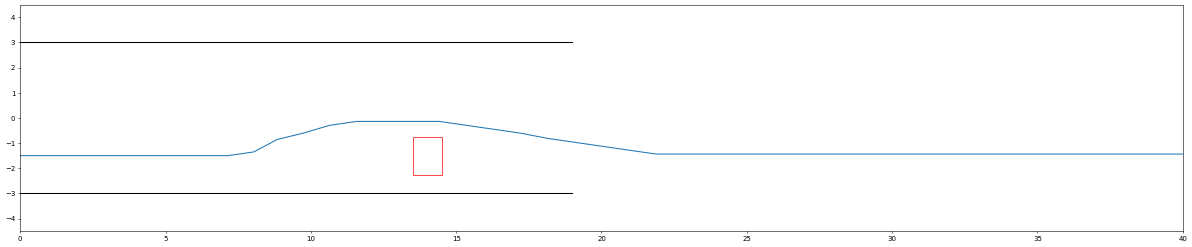

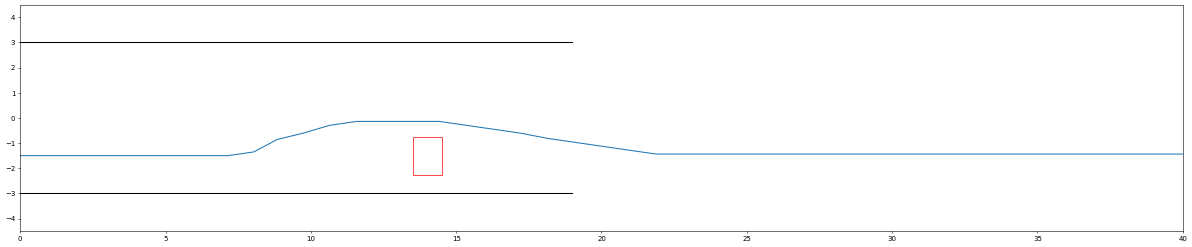

In [11]:
x = path.x_list
y = path.y_list
yaw = path.yaw_list
v = path.v_list

import matplotlib
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


plt.figure(figsize=(30, 6), dpi=50)

ego = Box2D(0.0, -1.5, 0.0, 6.0, 2.0, 1.2, "M") 
for i in range(len(x)):
    plt.clf()
    xy = np.array([x[i], y[i]])
    auto_rect = plt.Rectangle(xy-[ego.L/2.0, ego.W/2.0], 
                     ego.L, ego.W, angle=path.yaw_list[i]*180.0/np.pi, fc="none", ec='g')
    plt.gca().add_patch(auto_rect)
    for obs in obs_buf:
        obs_rect = plt.Rectangle(np.array([obs.traj[i].x, obs.traj[i].y])-[obs.L/2.0, obs.W/2.0], 
                                  obs.L, obs.W, angle=obs.traj[i].phi*180.0/np.pi, fc="none", ec='r')       
        plt.gca().add_patch(obs_rect)
    plt.plot(x, y)
    plt.plot(3*np.ones(20), 'k')
    plt.plot(-3*np.ones(20), 'k')
    plt.axis([0, 40, -4.5, 4.5])
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        